In [1]:
import functions as f
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import importlib
importlib.reload(f)

daily_omega = r"C:\\physics_masters\\data\\Bossa public market data\\pub\\daily\\omega\\"


In [13]:
importlib.reload(f)
dataframes = f.load_data_pol(daily_omega)
df_concat = f.concat_and_select(dataframes, 0.99, cpi_file='CPI_POL.csv') #0.99
df_concat, index_series = f.calculate_returns(df_concat)

% of stocks remaining: 12.50%
% of dates remaining: 99.89%
Number of stocks: 50
Number of dates: 3612
% of nans: 0.60%


<Axes: xlabel='Date'>

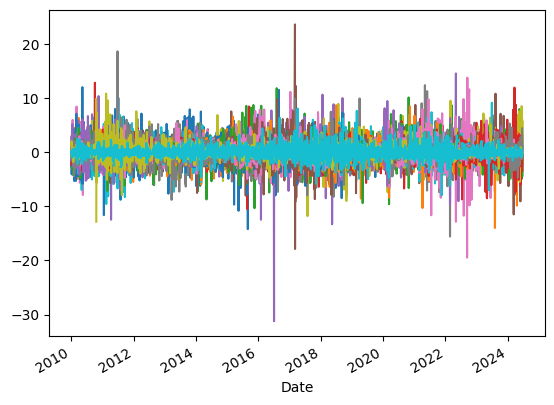

In [14]:
df_concat.plot(legend=False)

# Results

<I^2> = 0.1196
rho_0*sigma2_0 = 0.0666


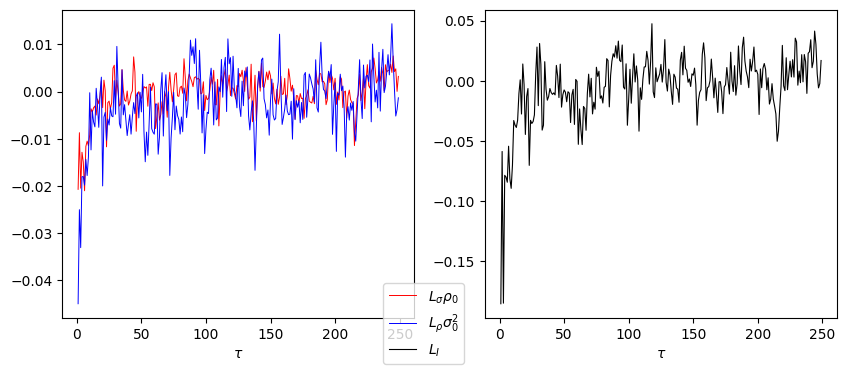

In [15]:
importlib.reload(f)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
data = f.calculate_correlation_functions(df_concat, index_series)

f.plot_correlation_functions(data, fig, ax)

# With real index WIG

% of stocks remaining: 100.00%
% of dates remaining: 100.00%
Number of stocks: 1
Number of dates: 3609
% of nans: 0.25%
<I^2> = 0.9997
rho_0*sigma2_0 = 0.0666


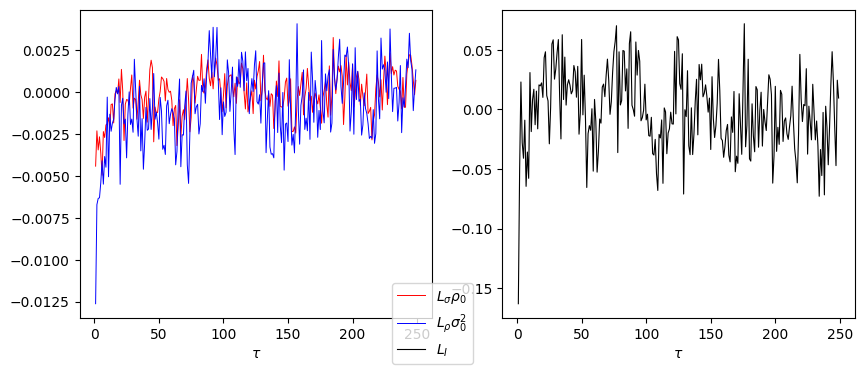

In [16]:
I = pd.read_csv('C:/physics_masters/data/Bossa public market data/pub/daily/omega/WIG.prn', delimiter=',', header=0, parse_dates=['Date'], usecols=['Date', 'Close'])
I.set_index('Date', inplace=True)
I.rename(columns={"Close": 'WIG'}, inplace=True)
I = f.concat_dfs_by_date([I])

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
data = f.calculate_correlation_functions(df_concat, I['WIG'])

f.plot_correlation_functions(data, fig, ax)